<a href="https://www.kaggle.com/code/catalystcooperative/03-eia-930-sanity-checks?scriptVersionId=235662903" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imputed Hourly Demand in PUDL
## Background
PUDL data includes multiple sources for hourly electricity demand data reported at various levels of spatial granularity. Namely, [FERC Form 714](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/ferc714.html) contains hourly demand by planning area, while [EIA Form 930](https://catalystcoop-pudl.readthedocs.io/en/latest/data_sources/eia930.html) contains hourly demand by Balancing Authority (BA) and BA subregion. In order to make this data more readily usable for cases which value completeness and smoothness of the data, we've developed a pipeline for imputing missing and anomolous data points.

Our imputation pipeline is adapted from this [implementation](https://github.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Code) by [Tyler Ruggles](https://github.com/truggles) and [Alicia Wongel](https://github.com/awongel). We also worked with Alicia to test and validate our work along the way. Despite the reference implementation being specifically developed for EIA 930, we initially adapted it for FERC 714 data, and only recently generalized our implementation to work with EIA 930 data. During this generalization process, we standardized how we structure and naming conventions for imputed data, and developed significant tooling for analyzing and validating the data. This notebook will demonstrate how to access this data, and what we've done to feel confident in our imputation. For a detailed description of our timeseries imputation methods, see the [docs](https://catalystcoop-pudl.readthedocs.io/en/latest/methodology/timeseries_imputation.html).

## Available Data
### General
- `core_pudl__codes_imputation_reasons` - Describes reasons a value was "flagged" for imputation

### FERC Form 714
- `out_ferc714__hourly_planning_area_demand` - Hourly demand by planning area

### EIA Form 930
- `out_eia930__hourly_operations` - Hourly demand by BA
- `out_eia930__hourly_subregion_demand` - Hourly subregion demand

## Approach to Validating Performance
When imputing data it can be difficult to validate the performance as the data we are imputing is inherently "bad", and so we will never know what the true values should be. To deal with this limitation, we've applied several different approaches to validation, which we use in conjunction to feel confident in our implementation.

The first approach is the simple "eye test". To do this, we plot sections of data and visually compare the imputed and reported data. While this is a basic approach it's an incredibly valuable way to quickly assess performance and check intuitive expectations.

Our second approach is to compare our results to the baseline implementation linked above. Since we had an existing example of imputed EIA 930 data, we were able to use this as a comparison for our results. This, of course, assumes the original implementation is performing well, but it at least gives confidence that we have not significantly diverged from this reference.

Finally, we have developed a simulation pipeline, which provides a more quantitative approach to validating performance. This approach finds sections of data where no values were flagged for imputation, and flags a number of these for a simulated imputation. We then can compare these imputed values to the original reported values and analyze the error for these values.

## Notebook Setup

In [2]:
!mamba install matplotx --quiet --yes

fish: Unknown command: mamba
fish: 
mamba install matplotx --quiet --yes
^~~~^


In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
import matplotx
matplotlib.style.use(matplotx.styles.onedark)

from pudl.analysis.timeseries_evaluation import plot_imputation, _filter_df

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data Access
 All of the tables listed above are available in PUDL nightly builds, and will be updated with new data as it becomes available. All of these tables can be accessed as a parquet file from a link like:

```
https://s3.us-west-2.amazonaws.com/pudl.catalyst.coop/nightly/{table_name}.parquet
```

Below we'll demonstrate loading a table from nightly builds into a Pandas DataFrame with the `core_pudl__codes_imputation_reasons` table.

In [3]:
def get_s3_nightly(table: str) -> pd.DataFrame:
    """Read data from our AWS open data registry S3 bucket."""
    return pd.read_parquet(f"s3://pudl.catalyst.coop/nightly/{table}.parquet")

get_s3_nightly("core_pudl__codes_imputation_reasons")

,code,description
0,missing_value,Indicates that reported value was already NULL.
1,anomalous_region,Indicates that value is surrounded by flagged ...
2,negative_or_zero,Indicates value is negative or zero.
3,identical_run,Indicates value is part of an identical run of...
4,global_outlier,Indicates value is greater or less than n time...
5,global_outlier_neighbor,Indicates value neighbors global outliers.
6,local_outlier_high,Indicates value is a local outlier on the high...
7,local_outlier_low,Indicates value is a local outlier on the low ...
8,double_delta,Indicates value is very different from neighbo...
9,single_delta,Indicates value is significantly different fro...


## Visualizing Imputed Data
An important part of the development process when creating our imputation pipeline was visual spot checking of imputed data. This allows us to qualitatively judge performance when it is often difficult to impossible to produce quantitative measurements. We'll implement a function below to identify sections of data where a relatively high proportion of values were flagged. By default this function will look for months of data where between 10-25% of values were flagged. This range tends to be interesting, as there's enough "bad" values to challenge the imputation, but not so many that there's insufficient "good" data for reference.

To actually create the plots, we'll use a funtion that we added to PUDL during development for easy access. This function will plot the reported data, imputed data, and identify which values were actually flagged and why.

### Identify regions of interest

In [72]:
def find_imputed_sections(
    df: pd.DataFrame,
    idx_cols: list[str],
    flag_col: str = "demand_imputed_pudl_mwh_imputation_code",
    min_imputation_rate: float = 0.1,
    max_imputation_rate: float = 0.25,
    num_samples: int = 3,
) -> pd.DataFrame:
    """Function to identify months with a relatively high rate of imputation.

    Args:
        df: DataFrame with imputed demand.
        id_cols: Set of columns that identify a unique respondent.
        flag_col: Column describing if/why row was selected for imputation.
        min_imputation_rate: Minimum ratio of values in month that were imputed.
        max_imputation_rate: Maximum ratio of values in month that were imputed (too high and
            the performance is no longer interesting as there's insufficient underlying data to reference).
        num_samples: How many months to return from selection.
    """
    monthly_imputation_rate = (
        (
            df.groupby(
                [*idx_cols, pd.Grouper(key="datetime_utc", freq="MS")], observed=True
            )[flag_col].apply(lambda x: x.notnull().mean())
        )
        .reset_index()
        .rename(columns={flag_col: "imputation_rate", "datetime_utc": "month"})
        .sort_values(by=["imputation_rate"], ascending=False)
    )
    return monthly_imputation_rate[
        (monthly_imputation_rate.imputation_rate >= min_imputation_rate) &
        (monthly_imputation_rate.imputation_rate <= max_imputation_rate) &
        (monthly_imputation_rate.month.dt.year < 2025)
    ].head(num_samples)

### EIA 930 Subregion Demand
We'll start with EIA 930 subregion demand using the function above to find months of interest.

In [73]:
# Load imputed subregion demand table from nightly builds
df = get_s3_nightly("out_eia930__hourly_subregion_demand")

# Find months with a high rate of imputation
subregion_idx_cols = ["balancing_authority_code_eia", "balancing_authority_subregion_code_eia"]
months_of_interest = find_imputed_sections(df, idx_cols=subregion_idx_cols)
months_of_interest

,balancing_authority_code_eia,balancing_authority_subregion_code_eia,month,imputation_rate
5145,SWPP,CSWS,2024-03-01,0.248656
4817,PNM,KCEC,2024-11-01,0.248611
291,CISO,VEA,2024-01-01,0.247312


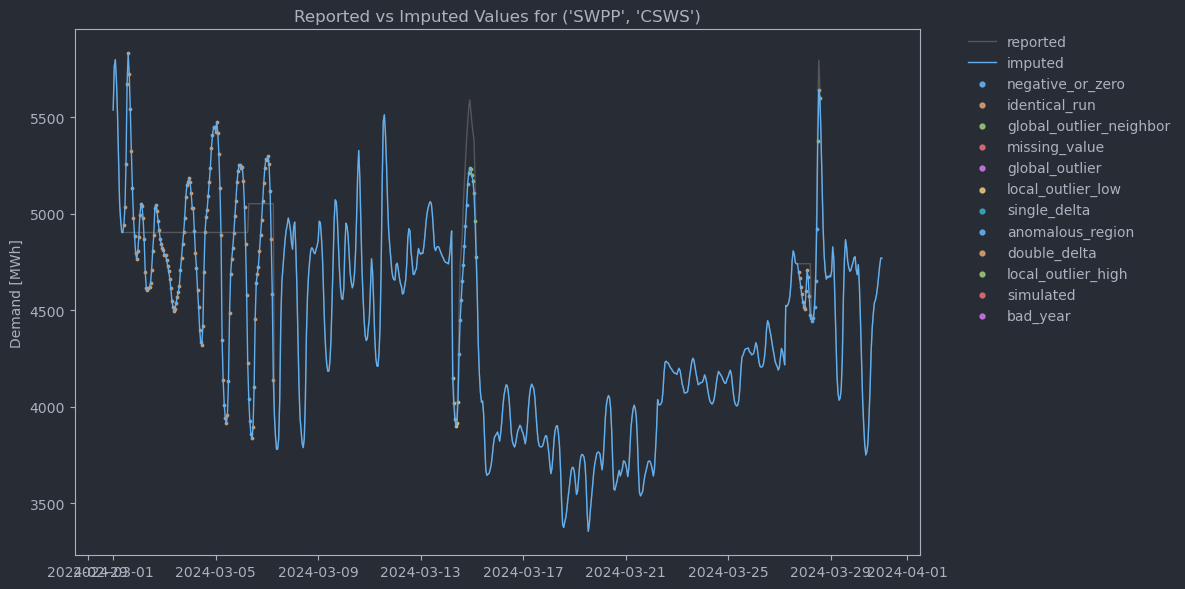

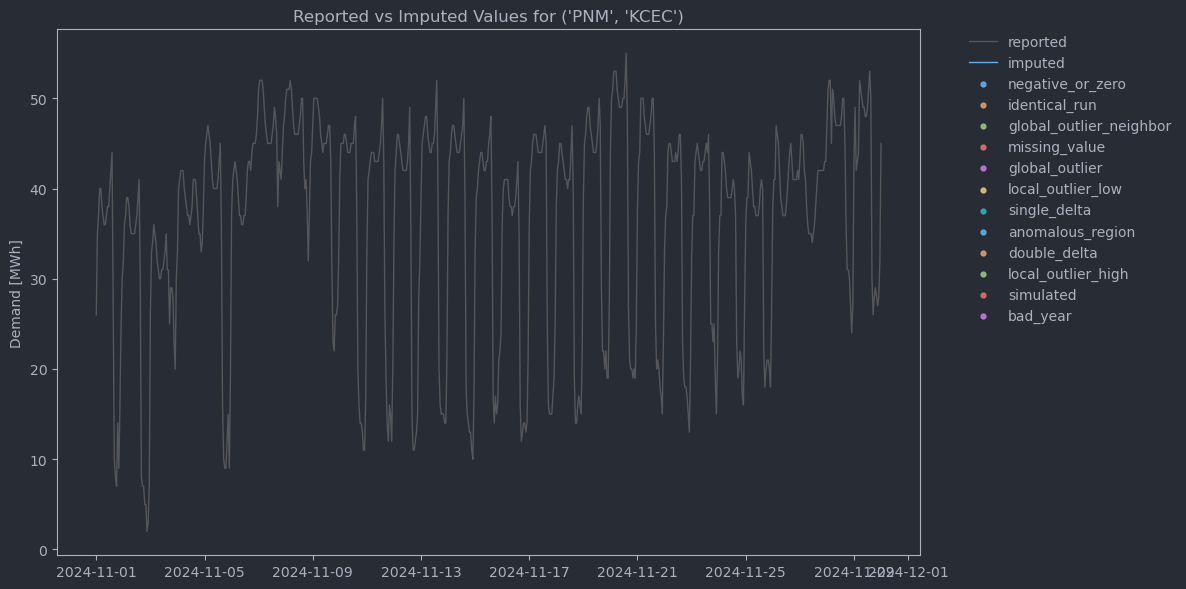

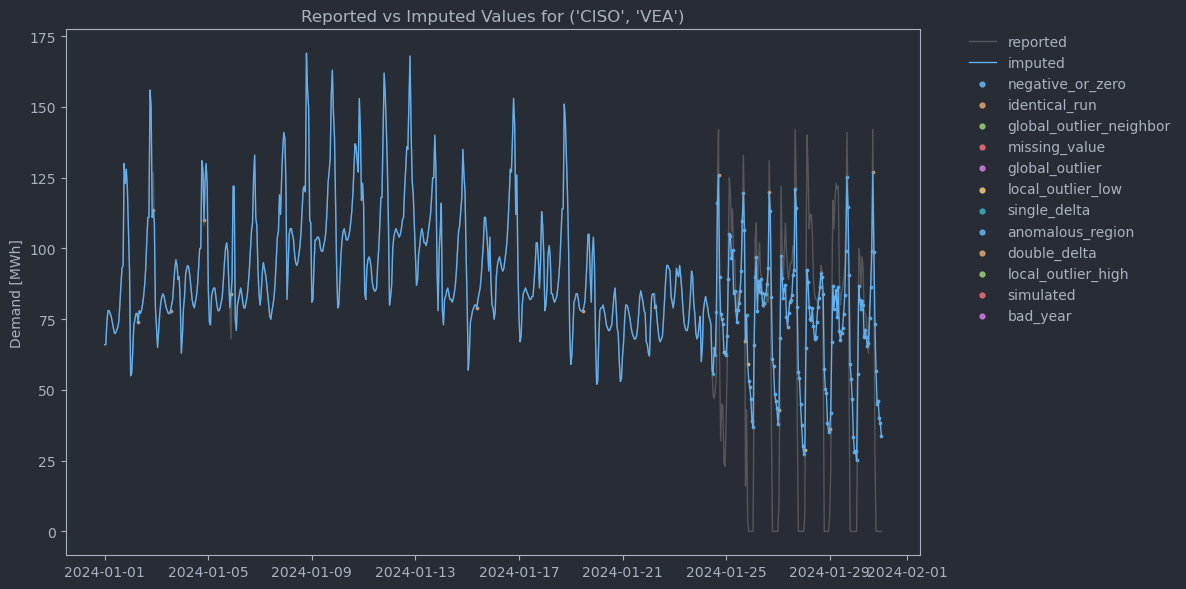

In [74]:
from pandas.tseries.offsets import MonthEnd

for month in months_of_interest.iterrows():
    plot_imputation(
        df,
        idx_cols=subregion_idx_cols,
        idx_vals=tuple(month[1][subregion_idx_cols]),
        start_date=month[1]["month"],
        end_date=month[1]["month"] + MonthEnd(),
        reported_col="demand_reported_mwh",
        imputed_col="demand_imputed_pudl_mwh",
    )

In these sections we can see several common features of the reported data that lead to flagging. For example, in the first plot, we see a large unnaturally flat section of reported data where the same value is repeated. Then, in the final plot, we see several smaller sections of flat data at the nadir of the curve. When we find several sections of anomoulous data grouped together like this, we end up flagging the values between these sections as well with the `anomalous_region` flag.

### EIA 930 BA Demand
Now we will repeat this process with EIA 930 BA demand.

In [75]:
# Load imputed subregion demand table from nightly builds
df = get_s3_nightly("out_eia930__hourly_operations")

# Find months with a high rate of imputation
ba_idx_cols = ["balancing_authority_code_eia"]
months_of_interest = find_imputed_sections(df, idx_cols=ba_idx_cols)
months_of_interest

,balancing_authority_code_eia,month,imputation_rate
1369,DOPD,2017-04-01,0.247222
6036,SPA,2022-06-01,0.245833
4420,PACE,2016-09-01,0.244444


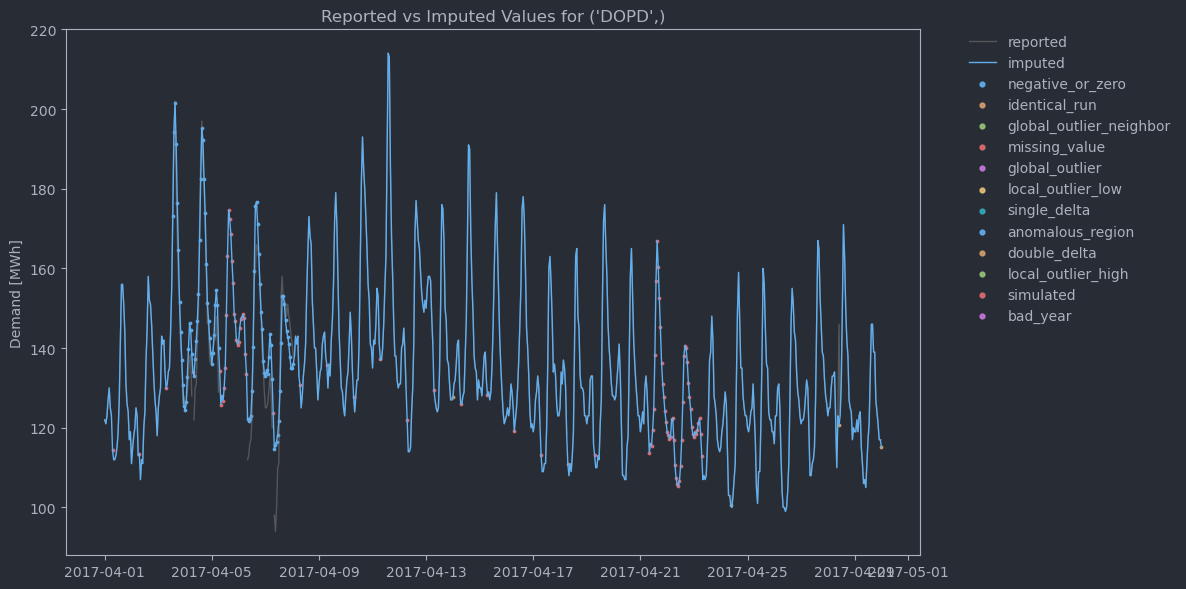

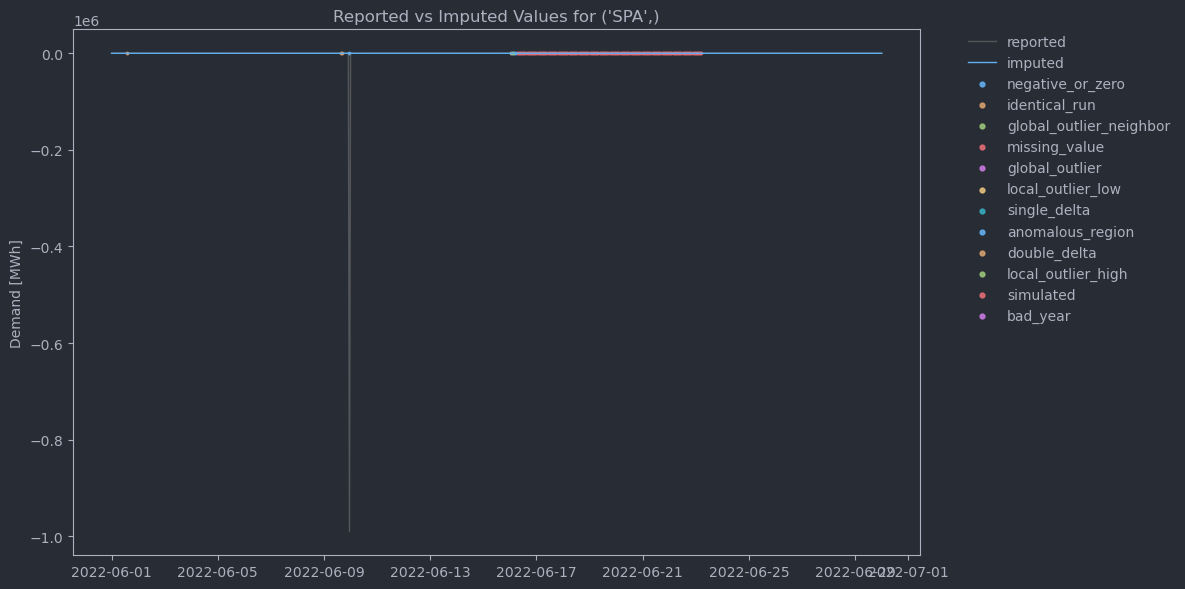

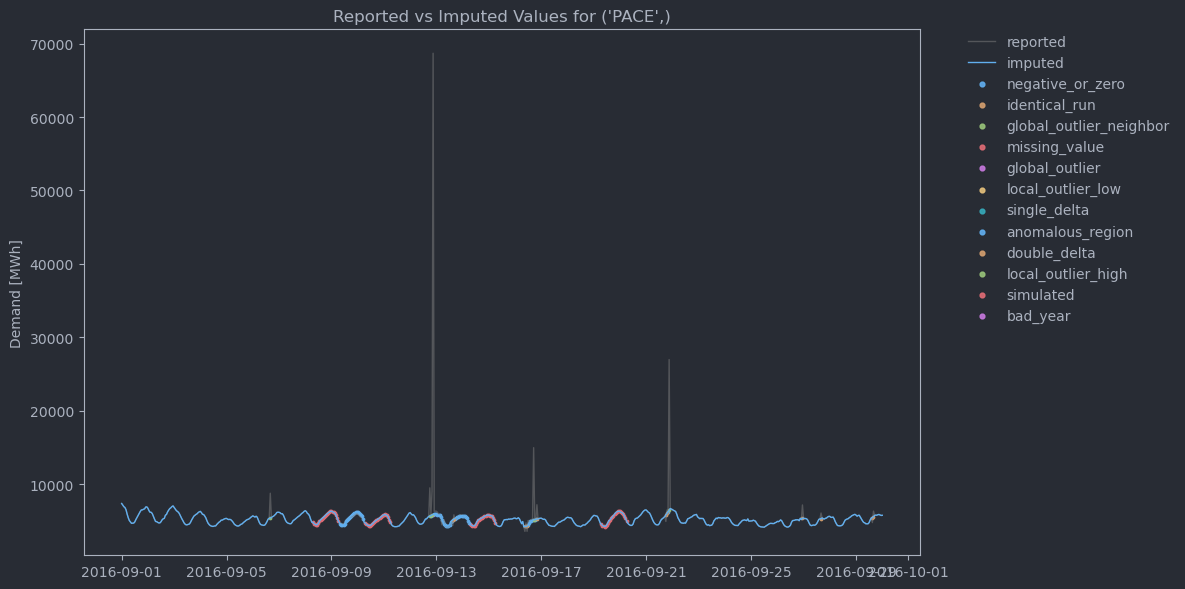

In [76]:
for month in months_of_interest.iterrows():
    plot_imputation(
        df,
        idx_cols=ba_idx_cols,
        idx_vals=tuple(month[1][ba_idx_cols]),
        start_date=month[1]["month"],
        end_date=month[1]["month"] + MonthEnd(),
        reported_col="demand_reported_mwh",
        imputed_col="demand_imputed_pudl_mwh",
    )

In the bottom two plots here we see some cases with significant outliers. In these cases, the outliers are large it can be hard to make out the details in the rest of the data, but we do see that these outliers are clearly removed in the imputed set.